In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold 

# Kuka Path Analysis
#### Steve Su 5/17/2022

## Goal  
Identify points where tracker data does not correspond with the path data and investigate where errors are occuring.  

## Method
It is assumed that the robot is successful when it: 1) matches the given x,y,z path position and 2) corresponds with the path unix timestamp.  Thus the two data sets need to be aligned so that we are only comparing the path and tracker points at the same timestamp.  This was done by interpolating the timestamps of the path to the tracker data.  These two data sets were then used to transform the tracker data into the same coordinate space as the path data using the Kabcsh algorithm.  

When applying the Kabcsh algorithm we only want to use the reference points which we know are correct to calculate the rotation and translation matrices.  These are the points at the beginning of the trial which show a stepped waveform (fig 2).  Subsequently, the rotation and translation matrices were determined and applied to the tracker data which transformed the data into the path coordinate space.  Now we can compute the error (distance) between each pair of tracker and path points.  

For futher investigation, the error was predicted using decision trees. The predictor variables were the x, y, z coordinates and step number.  The response variable was the postional error.  In practice one might want to predict the error and apply correction to the robot.  


## EDA
Exploratory data analysis shows that the input data of both path and tracker are fairly symmetric with no apparent outliers (fig.1).  No null values were found.  The registration points of the robot are assumed to occur during the first 18500 steps (fig. 2) because the waveform is stepped (slight pause) compared to continuous waveform during the forming operation.  The tracker data needs to be rotated and translated to match the path coordinate system (figs. 3,4) 

In [2]:
path = pd.read_csv('path.csv')
tracker = pd.read_csv('tracker.csv')

In [3]:
path.head(3)

,Unnamed: 0,index,x_pth,y_pth,z_pth,t_pth
0,0,177,450.0,700.0,1.136868e-13,1633969004350000000
1,1,178,450.0,700.0,0.000000e+00,1633969004400000000
2,2,179,450.0,700.0,0.000000e+00,1633969004450000000


In [4]:
#path.isnull().sum()
path.info()
path.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145841 entries, 0 to 145840
Data columns (total 6 columns):
Unnamed: 0    145841 non-null int64
index         145841 non-null int64
x_pth         145841 non-null float64
y_pth         145841 non-null float64
z_pth         145841 non-null float64
t_pth         145841 non-null int64
dtypes: float64(3), int64(3)
memory usage: 6.7 MB


,Unnamed: 0,index,x_pth,y_pth,z_pth,t_pth
count,145841.000000,145841.000000,145841.000000,145841.000000,1.458410e+05,1.458410e+05
mean,72920.000000,73097.000000,450.000030,700.000118,7.795259e-19,1.633973e+18
std,42100.814642,42100.814642,50.895629,88.157163,2.976942e-16,2.105041e+12
min,0.000000,177.000000,290.188669,380.377339,0.000000e+00,1.633969e+18
25%,36460.000000,36637.000000,437.120884,684.276047,0.000000e+00,1.633971e+18
50%,72920.000000,73097.000000,450.000000,700.000000,0.000000e+00,1.633973e+18
75%,109380.000000,109557.000000,462.864800,715.711192,0.000000e+00,1.633974e+18
max,145840.000000,146017.000000,609.811331,1019.622661,1.136868e-13,1.633976e+18


In [5]:
tracker.head(3)

,Unnamed: 0,index,x_trk,y_trk,z_trk,t_trk
0,0,3180,-36.507133,-40.170982,-2915.784424,1633969004633871000
1,1,3181,-36.543438,-40.260765,-2915.713623,1633969004648860000
2,2,3182,-36.645119,-40.364326,-2915.732910,1633969004662330000


In [6]:
#tracker.isnull().sum()
tracker.info()
tracker.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546943 entries, 0 to 546942
Data columns (total 6 columns):
Unnamed: 0    546943 non-null int64
index         546943 non-null int64
x_trk         546943 non-null float64
y_trk         546943 non-null float64
z_trk         546943 non-null float64
t_trk         546943 non-null int64
dtypes: float64(3), int64(3)
memory usage: 25.0 MB


,Unnamed: 0,index,x_trk,y_trk,z_trk,t_trk
count,546943.000000,546943.000000,546943.000000,546943.000000,546943.000000,5.469430e+05
mean,273471.000000,276651.000000,-36.687327,-40.464718,-2915.682662,1.633973e+18
std,157888.988478,157888.988478,82.037850,15.971601,57.930370,2.105317e+12
min,0.000000,3180.000000,-337.903320,-97.966225,-3137.565430,1.633969e+18
25%,136735.500000,139915.500000,-49.492115,-44.239212,-2927.413086,1.633971e+18
50%,273471.000000,276651.000000,-36.506119,-40.445515,-2915.592285,1.633973e+18
75%,410206.500000,413386.500000,-23.823558,-36.735634,-2904.007812,1.633974e+18
max,546942.000000,550122.000000,264.400818,16.845316,-2693.563965,1.633976e+18


Text(0.5, 1.0, 'Path - Histogram z Values')

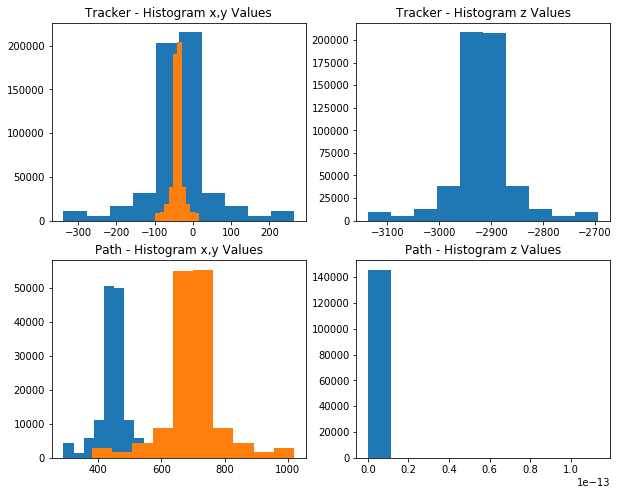

In [7]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10,8))

ax[0,0].hist(tracker['x_trk'])
ax[0,0].hist(tracker['y_trk'])
ax[0,0].set_title('Tracker - Histogram x,y Values')

ax[0,1].hist(tracker['z_trk'])
ax[0,1].set_title('Tracker - Histogram z Values')
ax[1,0].hist(path['x_pth'])
ax[1,0].hist(path['y_pth'])
ax[1,0].set_title('Path - Histogram x,y Values')
ax[1,1].hist(path['z_pth'])
ax[1,1].set_title('Path - Histogram z Values')
#plt.hist(tracker['z_trk'])


#### Fig. 1
Histograms of tracker and path x, y, z values.  The path values for the z coordinates are pretty much all zeros, note 1e-13.  

Text(0.5, 1.0, 'Registration Points - Tracker z_trk vs step #')

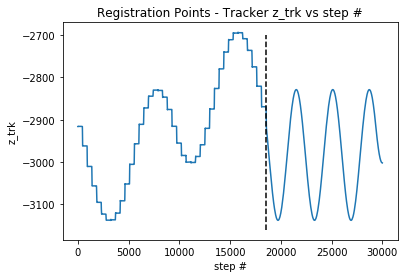

In [8]:
%matplotlib inline
num_pts = 30000
plt.plot(np.arange(num_pts), tracker['z_trk'][0:num_pts])
plt.plot([18500,18500], [-3160,-2700], c= 'k', ls= '--' )
plt.xlabel('step #')
plt.ylabel('z_trk')
plt.title("Registration Points - Tracker z_trk vs step #")


#### Fig. 2
The stepped waveform from step 0 to step 18500 is assumed to be where the registration points were taken during robot calibration

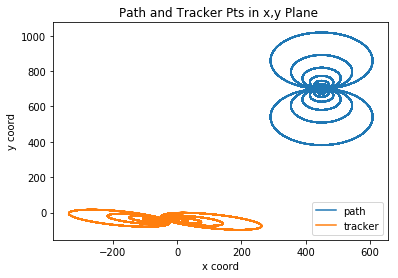

In [9]:
%matplotlib inline
plt.plot(path.x_pth[0:], path.y_pth[0:], label='path')
plt.plot(tracker.x_trk[0:], tracker.y_trk[0:], label='tracker')
plt.xlabel('x coord')
plt.ylabel('y coord')
plt.title("Path and Tracker Pts in x,y Plane ")
plt.legend(loc='lower right');

#### Fig. 3
Tracker and path data plotted in xy plane.

Text(0.5, 0.92, 'Path and Tracker Pts in x,y,z')

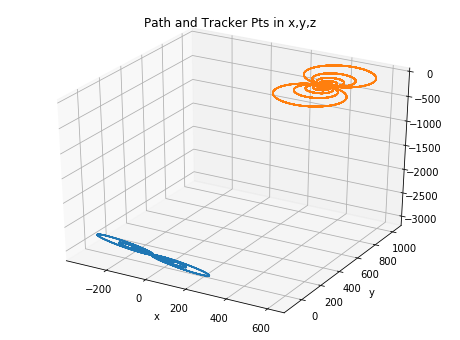

In [10]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6)) 
ax = fig.add_subplot(111,projection='3d') 

num_pts = 100000
ax.plot(tracker.x_trk[0:num_pts], tracker.y_trk[0:num_pts], tracker.z_trk[0:num_pts])
ax.plot(path.x_pth[0:num_pts], path.y_pth[0:num_pts], path.z_pth[0:num_pts])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Path and Tracker Pts in x,y,z")

#### Fig. 4
Tracker and path data plotted in xyz.

## Data Preparation  
Path and Tracker data are synched to the same unix time stamp by interpolation and put into a dataframe before data transformation process.  

In [11]:
i = 0  #index for path dataframe
j = 0  #index for tracker dataframe
k = 0  #index for tracker dataframe
dct = {'time':[], 'x_trk':[], 'y_trk':[], 'z_trk':[], 'ijk':[]}  #where key='ijk' is used for verification purposes
while i < len(path):
    while path.t_pth[i] <= tracker.t_trk[j]: 
        i += 1
    k = j + 1
    while path.t_pth[i] >= tracker.t_trk[k]:
            k += 1
    #now i, j, k are established for interpolation
    #this relation must always hold: tracker.t_trk[j] < path.t_pth[i] < tracker.t_trk[k] 
    percent = (path.t_pth[i] - tracker.t_trk[j]) / (tracker.t_trk[k] - tracker.t_trk[j])
    x = tracker.x_trk[j] + (tracker.x_trk[k] - tracker.x_trk[j]) * percent
    y = tracker.y_trk[j] + (tracker.y_trk[k] - tracker.y_trk[j]) * percent
    z = tracker.z_trk[j] + (tracker.z_trk[k] - tracker.z_trk[j]) * percent
    dct['time'].append(path.t_pth[i])
    dct['x_trk'].append(x)
    dct['y_trk'].append(y)
    dct['z_trk'].append(z)
    dct['ijk'].append((i,j,k))
    #remeber to increment for next iteration
    i += 1
    j = k + 1

In [12]:
#for the purpose of self checks of code above: interpolated values should be between i.e. tracker.x_trk[j], tracker.x_trk[k]
'''
%matplotlib inline
n = 20
index_i = [tupl[0] for tupl in dct['ijk']][:n]
index_j = [tupl[1] for tupl in dct['ijk']][:n]
index_k = [tupl[2] for tupl in dct['ijk']][:n]

plt.scatter(np.arange(n), tracker.x_trk[index_j]) 
plt.scatter(np.arange(n), tracker.x_trk[index_k])
plt.scatter(np.arange(n), dct['x_trk'][0:n]) 
plt.title('quick check - green points are interpolated')
'''

"\n%matplotlib inline\nn = 20\nindex_i = [tupl[0] for tupl in dct['ijk']][:n]\nindex_j = [tupl[1] for tupl in dct['ijk']][:n]\nindex_k = [tupl[2] for tupl in dct['ijk']][:n]\n\nplt.scatter(np.arange(n), tracker.x_trk[index_j]) \nplt.scatter(np.arange(n), tracker.x_trk[index_k])\nplt.scatter(np.arange(n), dct['x_trk'][0:n]) \nplt.title('quick check - green points are interpolated')\n"

In [13]:
#for ease and to prevent confusion, combine path and tracker data into one dataframe
index_i = [tupl[0] for tupl in dct['ijk']] 
pth_cols = ['x_pth', 'y_pth', 'z_pth', 't_pth']
trk_cols = ['x_trk', 'y_trk', 'z_trk', 'time']


In [14]:
#the interpolated track data set
track_i = pd.DataFrame(dct, columns = trk_cols)
track_i.head(3)

,x_trk,y_trk,z_trk,time
0,-36.585336,-40.280559,-2915.755229,1633969004650000000
1,-36.682439,-40.428618,-2915.709910,1633969004700000000
2,-36.756237,-40.518059,-2915.838187,1633969004750000000


In [15]:
#path data set whose index matches the track_i dataframe, note the times match between the data frames 
path_i = path.iloc[index_i][pth_cols]  #we want to use iloc to match index_i
path_i.head(3)

,x_pth,y_pth,z_pth,t_pth
6,450.0,700.0,0.0,1633969004650000000
7,450.0,700.0,0.0,1633969004700000000
8,450.0,700.0,0.0,1633969004750000000


Text(0.5, 1.0, 'end of registration point collection ')

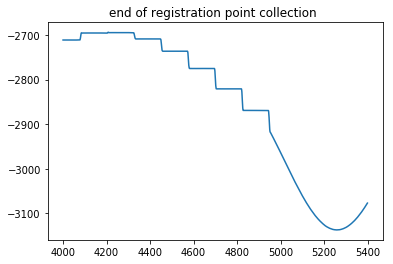

In [16]:
%matplotlib inline
plt.plot(track_i.z_trk[4000:5400])
plt.title('end of registration point collection ')

## Transform the Tracker Data - Kabsch Algorithm

In [17]:
def get_rot_offset(ref, untransformed, calibration_index): 
    '''
    find rotation and translation matrix between a reference and a sample matrix using Kabsch Algorithm
    parameters: ref:reference matrix (ndarray), untransformed: untransformed matrix (ndarray), calibration_index: start of valid data (int)
    return: r: rotation matrix (ndarray), offset: translation matrix (ndarray)
    '''
    untrans_data = untransformed.copy()  
    ref_data = ref.copy()
    untrans_centroid = np.average(untrans_data, axis=0) 
    ref_centroid = np.average(ref_data, axis=0)
    untrans_data -= untrans_centroid  #data is now centered at 0,0
    ref_data -= ref_centroid
    
    #referenced this source: https://stackoverflow.com/questions/60877274/optimal-rotation-in-3d-with-kabsch-algorithm
    h = untrans_data[0:calibration_index, :].T @ ref_data[0:calibration_index, :]  #3xn, nx3 -> 3x3
    u, s, vt = np.linalg.svd(h)
    v = vt.T
    d = np.linalg.det(v @ u.T)
    e = np.array([[1, 0, 0], [0, 1, 0], [0, 0, d]])
    r = v @ e @ u.T  #rotation matrix
    offset = ref_centroid
    return r, offset

def get_transformed_matrix(rot, offset, untrans):
    '''
    transform a matrix by rotation and translation matrices
    parameters: rot: rotation matrix (ndarray), offset: translation matrix (ndarray), untrans: matrix you want to transform (ndarray)
    return: output: transformed matrix(ndarray)
    '''
    untrans_mat = untrans.copy()
    untrans_centroid = np.average(untrans_mat, axis=0)
    untrans_mat -= untrans_centroid  #data is now centered at 0,0
   
    output = rot @ untrans_mat.T
    output = output.T + offset
    return output 

In [18]:
#Transform the tracker data
calibration_index = 4900  #corresponds to end of reference points during calibration tracker 
ref_points = np.array(path_i)[:,0:3]
untrans_points = np.array(track_i)[:,0:3]
rot, offset = get_rot_offset(ref_points, untrans_points, calibration_index)
track_transformed = get_transformed_matrix(rot, offset, untrans_points)

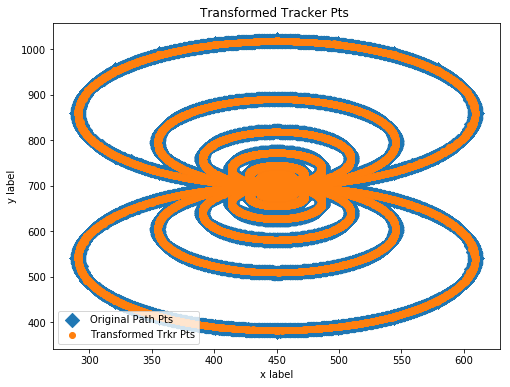

In [19]:
%matplotlib inline
start = 0
num_pts = len(path_i) 
plt.figure(figsize=(8, 6))
plt.scatter(ref_points[start:num_pts, 0], ref_points[start:num_pts, 1], marker='D', s=100, label='Original Path Pts')
plt.scatter(track_transformed[start:num_pts, 0], track_transformed[start:num_pts, 1], label='Transformed Trkr Pts') 
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("Transformed Tracker Pts ")
plt.legend(loc='lower left');

#### Fig. 5
Tracker data after transformation, points line up well with the path's coordinate system.

## Calculate the Error (Euclid Dist)

In [20]:
#err_xy = np.sqrt(np.sum(np.power(track_transformed[:,0:2] - ref_points[:, 0:2], 2), axis=1))
err_xyz = np.sqrt(np.sum(np.power(track_transformed[:,0:3] - ref_points[:, 0:3], 2), axis=1))

Text(0.5, 1.0, 'Error vs Step # (start to finish)')

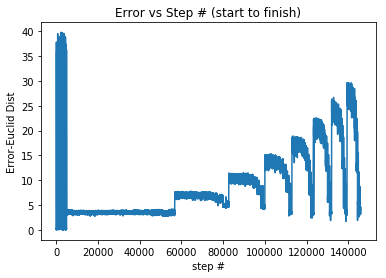

In [21]:
%matplotlib inline
plt.plot(np.arange(len(err_xyz)), err_xyz)
plt.xlabel('step #')
plt.ylabel('Error-Euclid Dist')
plt.title("Error vs Step # (start to finish)")

#### Fig. 6 
Error plot as the robot goes through its operation from start to finish.  There are some large errors at the beginning of the operation; they subside and then increase and decrease in cycles.  The plot below examines the errors at the beginning of the operation in detail.

Text(0.5, 1.0, 'Error at Registration Points (Calibration) at Beginning of Operation')

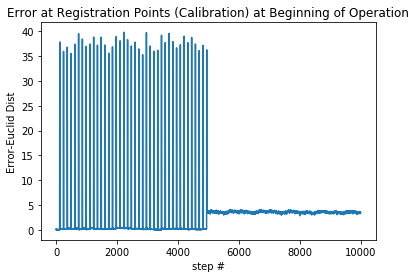

In [22]:
%matplotlib inline
plt.plot(err_xyz[0:10000])
plt.xlabel('step #')
plt.ylabel('Error-Euclid Dist')
plt.title("Error at Registration Points (Calibration) at Beginning of Operation")

#### Fig. 7
Error plot during the start of the operation. There are elevated errors during collection of the registration points whose cause is unknown. 

In [23]:
#points where error is greater than 5
#np.arange(5000)[err_xyz[:5000] > 5]

## Error Investigation with Respect to Position
To study the relation between the error and position, each one of the cycles in the error plot was examined. The tracker data was plotted in the x,y plane with a color code corresponding to its error.   

Text(0.5, 1.0, 'One Cycle in the Error vs Step Plot ')

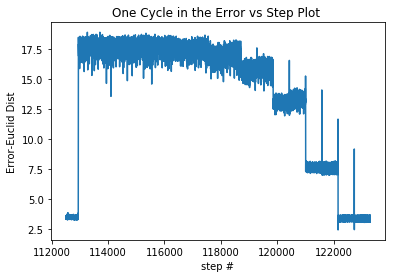

In [24]:
%matplotlib inline
#plt.plot(err_xy)
start = 112500
stop = 123300 #len(err_xyz)
#plt.scatter(np.arange(len(err_xyz))[start:stop], err_xyz[start:stop], s=1 )
plt.plot(np.arange(len(err_xyz))[start:stop], err_xyz[start:stop] )
plt.xlabel('step #')
plt.ylabel('Error-Euclid Dist')
plt.title("One Cycle in the Error vs Step Plot ")

#### Fig. 8
Error plot for one cycle between step#s 112500 and 123300. Only one cycle is examined at a time to study where the positional errors occur in the tracking data.  Shown in plot below.

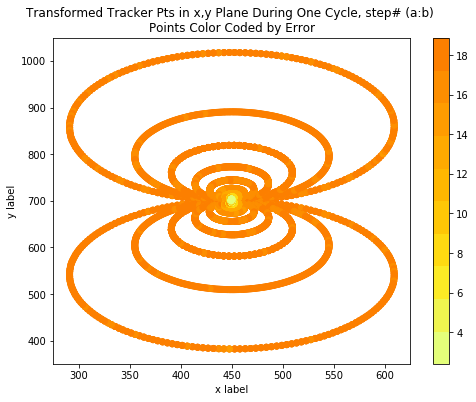

In [25]:
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.scatter(track_transformed[start:stop, 0], track_transformed[start:stop, 1], 
             c=err_xyz[start:stop], cmap=plt.get_cmap('Wistia', 10), label='Transformed Trkr Pts') 
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("Transformed Tracker Pts in x,y Plane During One Cycle, step# (a:b) \nPoints Color Coded by Error")
plt.colorbar()

#### Fig. 9
Transformed tracker pts in x,y plane during one cycle.  Lowest errors are located at the center and everything outside the center have errors near the maximum.  Although not shown here, the other cycles show similar behavior.

## Error Prediction Models
The visual plots give a good indication were the positional errors are distributed.  However with large number of predictors or more complex feature to response variable relationship, a machine learning algorithm would be needed to predict the positional error.  Not knowing the exact application here, I would assume that one of the goals is to predict the error and have the robot compensate for it during the forming process.  With this in mind, I created models to predict the errors even if this isn't the most complete data set to use. The predictors were the transformed x, y, z positions and step number for the entire operation, unlike in the previous example where I only examined one cycle.  The response was the position error.  Random Forest and Adaboost regression trees were the models.  The number of trees (hyperparameter) was selected using 5 fold CV with mean absolute error (MAE) as the metric.  The two models were compared using test data (withheld from training process) with, again, MAE as the metric.        

In [39]:
#randonmize and split data into training and test
n = len(track_transformed)
data_x = np.hstack((track_transformed, np.reshape(np.arange(n), (n, 1))))  #add step# as a predictor
data_y = err_xyz.copy()
indices = np.random.choice(np.arange(n), size=20000, replace=False)  #using a reduced data set of 20000 random points without replacement
data_x = data_x[indices]
data_y = data_y[indices]
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=42)

In [40]:
#hyperparameter optimization of n_estimators using 5 fold CV

folds = 5
kf = KFold(folds)
score_rf = []
score_adabst = []
for i in range(25, 300, 25):
    sum_mae_rf = 0
    sum_mae_adabst = 0
    rf = RandomForestRegressor(n_estimators = i, random_state = 42)
    adabst = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators = i, random_state=42)

    for train_index, val_index in kf.split(X_train):
        X_trn , X_val = X_train[train_index,:], X_train[val_index,:]
        y_trn , y_val = y_train[train_index] , y_train[val_index]  
        
        rf.fit(X_trn, y_trn)
        pred_rf = rf.predict(X_val)
        MAE_rf = np.mean(abs(pred_rf - y_val))
        sum_mae_rf += MAE_rf
        
        adabst.fit(X_trn, y_trn)
        pred_adabst = adabst.predict(X_val)
        MAE_adabst = np.mean(abs(pred_adabst - y_val))
        sum_mae_adabst += MAE_adabst
        
    score_rf.append(sum_mae_rf/folds) 
    score_adabst.append(sum_mae_adabst/folds)

In [45]:
#cv scores for each #of trees
[score_rf, score_adabst]

[[0.30735764362287876,
  0.3019723128983983,
  0.297163466147529,
  0.295071167966154,
  0.2943954090411226,
  0.2939864142017302,
  0.29333754670499596,
  0.29305066720110184,
  0.29258313065279123,
  0.2923042475586617,
  0.2922513367688227],
 [1.9019997789951688,
  3.2862648004625945,
  3.673156581977569,
  3.8362845317169585,
  3.9546023777171775,
  4.053567485989914,
  4.095269821395034,
  4.0945525706229535,
  4.090188817722229,
  4.090188817722229,
  4.090188817722229]]

Text(0.5, 0, 'No. of Trees')

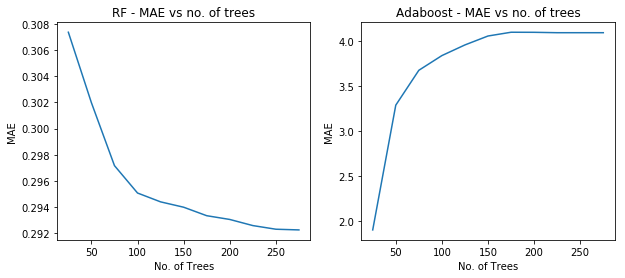

In [42]:
%matplotlib inline
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(range(25, 300, 25), score_rf)
plt.title('RF - MAE vs no. of trees')
plt.ylabel('MAE')
plt.xlabel('No. of Trees')
plt.subplot(122)
plt.plot(range(25, 300, 25), score_adabst)
plt.title('Adaboost - MAE vs no. of trees')
plt.ylabel('MAE')
plt.xlabel('No. of Trees')

#### Fig. 10
Random forest performance is starting to plateau when number of trees is 250.  Extending the plot by running more trees could help confirm this. For Adaboost its optimal performance is  around 25 trees.  Note, y axes are not at same scale but Random Forest has lower MAE values than Adaboost, indicating better performance.

In [44]:
#Use optimized values for n_estimators and find MAE test scores for both tree models
rf_best = RandomForestRegressor(n_estimators=300, random_state=42)
adabst_best = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=25, random_state=42)

rf_best.fit(X_train, y_train)
pred_rf_best = rf_best.predict(X_test)
MAE_rf_best = np.mean(abs(pred_rf_best - y_test))

adabst_best.fit(X_train, y_train)
pred_adabst_best = adabst_best.predict(X_test)
MAE_adabst_best = np.mean(abs(pred_adabst_best - y_test))

[MAE_rf_best, MAE_adabst_best]

[0.2718804499592104, 1.826095518407919]

## Summary
The transformation of the tracker data appears to map well to the path's coordinate system.  It was observed that the path's z values are all zero and the tracker points which did not get transformed to zero might be due to measurement noise.  After transformation, the positional errors could now be calculated in the same coordinate system.  These errors had a cyclic pattern, and with each subsequent cycle the maximun error increased.  The location where the positional errors were the lowest was at the centroid.  I assumed one the objectives at Machina would be to predict the errors and have the robot compensate for it.  Even if this data set may not be complete for such a task, I created two regression tree models.  One was a Random Forest and the other was Adaboost.  I did a optimization on the number of trees in the ensemble using 5 fold CV using a reduced data set with MAE as the metric.  The Random Forest model performed better with a test MAE of 0.27 vs the Adaboost model with test MAE of 1.82.  To put the Random Forest's MAE into context, it is less than 5% of the average positional error during the entire operation.  